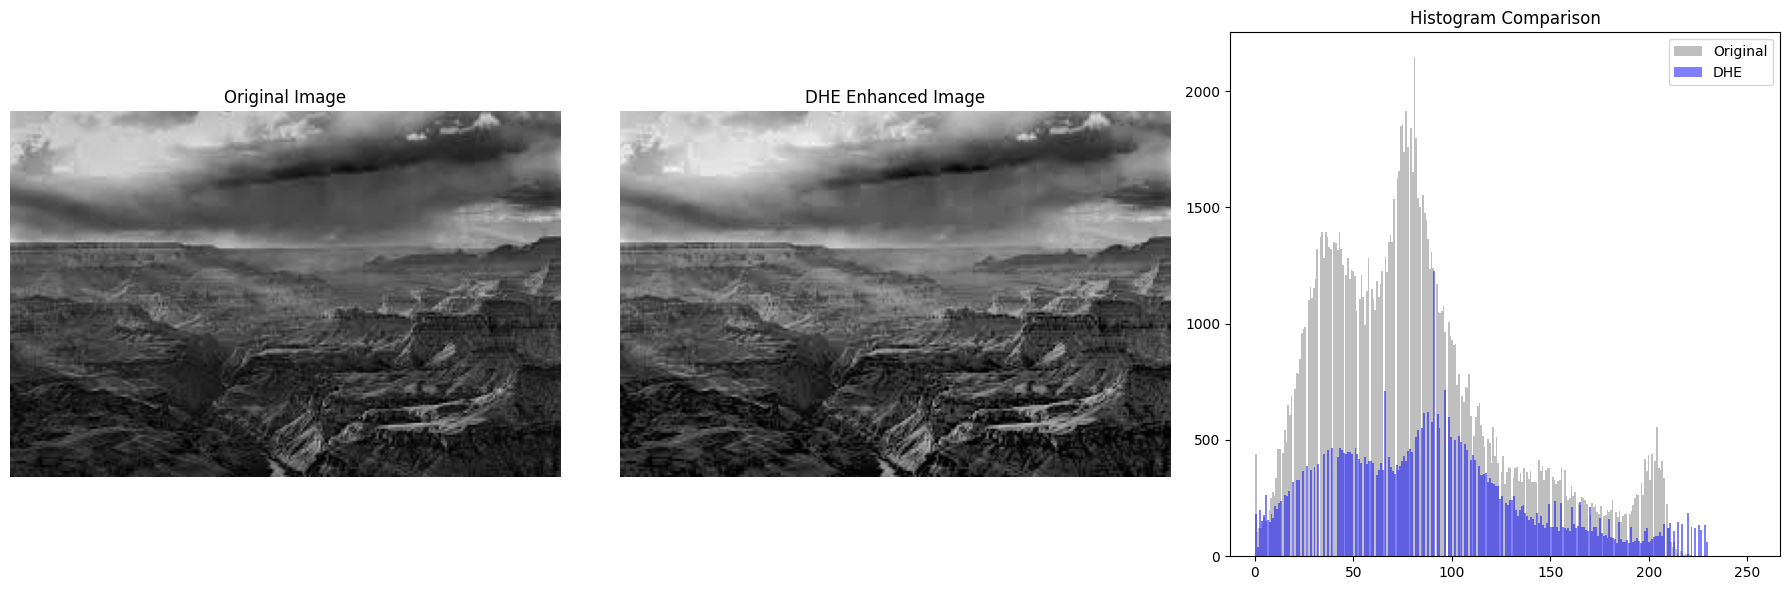

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_ubyte
from scipy.ndimage import gaussian_filter1d
import tkinter as tk
from tkinter import filedialog

def dynamic_histogram_equalization(image, x=0):
    if image.ndim == 3:
        image = color.rgb2gray(image)
        image = img_as_ubyte(image)

    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    smoothed_hist = gaussian_filter1d(hist.astype(float), sigma=1)

    local_minima = [0]
    for i in range(1, 255):
        if smoothed_hist[i] < smoothed_hist[i - 1] and smoothed_hist[i] < smoothed_hist[i + 1]:
            local_minima.append(i)
    local_minima.append(255)

    partitions = []
    for i in range(len(local_minima) - 1):
        m1 = local_minima[i]
        m2 = local_minima[i + 1]
        sub_hist = hist[m1:m2 + 1]
        if sub_hist.sum() == 0:
            continue
        partitions.append((m1, m2, sub_hist))

    spans = [p[1] - p[0] for p in partitions]
    cfs = [p[2].sum() for p in partitions]
    factors = [(spans[i] * (np.log(cfs[i] + 1))) for i in range(len(partitions))]
    total_factor = sum(factors)
    ranges = [int((f / total_factor) * 255) for f in factors]

    total_range = sum(ranges)
    if total_range < 255:
        ranges[-1] += 255 - total_range

    output_image = np.zeros_like(image)
    current_gray = 0
    for i, (m1, m2, sub_hist) in enumerate(partitions):
        if sub_hist.sum() == 0 or ranges[i] == 0:
            continue
        sub_image_mask = (image >= m1) & (image <= m2)
        cdf = sub_hist.cumsum()
        cdf_normalized = (cdf - cdf.min()) * ranges[i] / (cdf.max() - cdf.min() + 1e-5)
        cdf_normalized = cdf_normalized.astype(np.uint8) + current_gray
        lut = np.zeros(256, dtype=np.uint8)
        lut[m1:m2 + 1] = cdf_normalized
        output_image[sub_image_mask] = lut[image[sub_image_mask]]
        current_gray += ranges[i]

    return output_image

image = io.imread("D:\\Academic\\Semester\\Digital Image Lab\\images (1).jpeg")
enhanced_image = dynamic_histogram_equalization(image)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(image, cmap='gray' if image.ndim == 2 else None)
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(enhanced_image, cmap='gray')
axs[1].set_title('DHE Enhanced Image')
axs[1].axis('off')
axs[2].hist(image.flatten(), bins=256, color='gray', alpha=0.5, label='Original')
axs[2].hist(enhanced_image.flatten(), bins=256, color='blue', alpha=0.5, label='DHE')
axs[2].set_title('Histogram Comparison')
axs[2].legend()
plt.tight_layout()
plt.show()
